## Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

## Read Data

In [2]:
X = pd.read_csv('./data/light_500m.csv', header=-1)
print(X.shape)
print(X.head())

(28955, 4)
        0       1          2  3
0  121.04  30.700  12.973063  5
1  121.04  30.705  11.317718  5
2  121.04  30.710   7.650620  4
3  121.04  30.715   2.057491  6
4  121.04  30.720   2.039985  4


## Compute DBSCAN

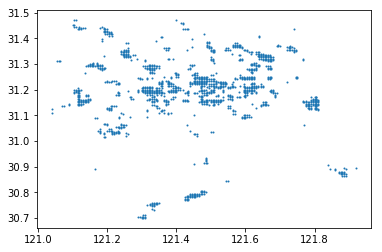

Estimated number of cluster: 15


In [3]:
import matplotlib.pyplot as plt
X = X[X[2]>40]
X = X.iloc[:,0:2]
plt.plot(X.iloc[:,0],X.iloc[:,1],'o',markersize=1)
plt.show()
db = DBSCAN(eps=0.03, min_samples=10).fit(X.iloc[:,0:2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


#Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of cluster: %d' % n_clusters_)
# print('Homogeneity: %0.3f' % metrics.homogeneity_score(labels_true, labels))
# print('Completeness: %0.3f' % metrics.completeness_score(labels_true, labels))

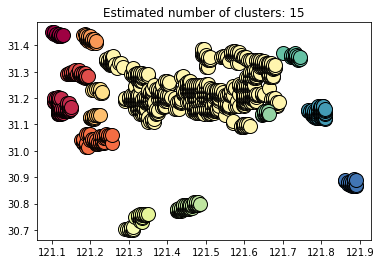

In [4]:
import matplotlib.pyplot as plt 
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


In [5]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters = 30).fit(X)
print(y_pred.cluster_centers_)

[[ 121.2177551    31.03867347]
 [ 121.60788889   31.25655556]
 [ 121.25625      31.34097222]
 [ 121.45611111   30.79055556]
 [ 121.43975      31.252625  ]
 [ 121.79457746   31.14464789]
 [ 121.39375      31.20051471]
 [ 121.8775       30.87931818]
 [ 121.11952381   31.1647619 ]
 [ 121.49293333   31.16286667]
 [ 121.5822093    31.35755814]
 [ 121.1982       31.4226    ]
 [ 121.32285714   30.73482143]
 [ 121.729375     31.36      ]
 [ 121.16         31.29302632]
 [ 121.49724138   31.35362069]
 [ 121.65260274   31.31616438]
 [ 121.59827586   31.11396552]
 [ 121.32791667   31.2803125 ]
 [ 121.53964912   31.20491228]
 [ 121.22934783   31.2073913 ]
 [ 121.48341463   31.2270122 ]
 [ 121.35271429   31.13585714]
 [ 121.68042857   31.20214286]
 [ 121.39631579   31.40447368]
 [ 121.4715625    30.976875  ]
 [ 121.32796512   31.19319767]
 [ 121.21421053   31.11684211]
 [ 121.11607143   31.44571429]
 [ 121.61150794   31.20031746]]


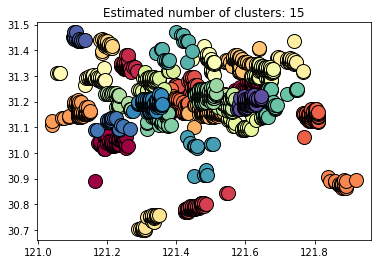

In [6]:
k_labels = y_pred.labels_
k_unique_labels = set(y_pred.labels_)
k_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(k_unique_labels))]
for k, col in zip(k_unique_labels, k_colors):
    class_member_mask = (k_labels == k)
    
    xy = X[class_member_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [12]:
centers = pd.DataFrame(y_pred.cluster_centers_, columns=['lng','lat'])
centers.to_csv('./data_processed/light_centers.csv', index=False)

## 读入数据

In [15]:
data = pd.read_csv('./data_processed/gshopInfo美食_processed.csv', header=0, na_values=['NULL',''])
data.shape

(29303, 11)

In [16]:
data.dtypes

shopId                int64
shopName             object
shopGlng            float64
shopGlat            float64
shopPower           float64
shopType            float64
mainCategoryName     object
categoryURLName      object
shopGroupId         float64
categoryName         object
comNum              float64
dtype: object

## 舍弃缺失值

In [17]:
data.apply(lambda x:sum(x.isnull()))

shopId                0
shopName              0
shopGlng             15
shopGlat             14
shopPower            36
shopType             93
mainCategoryName    171
categoryURLName     240
shopGroupId         353
categoryName        603
comNum                4
dtype: int64

In [18]:
data = data.dropna()
data.shape

(28696, 11)

## 将经纬度转换为距离

In [19]:
from math import radians, cos, sin, asin, sqrt
def geodistance(lng1, lat1, lng2, lat2):
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    dlon = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    dis = 2 * asin(sqrt(a)) * 6371
    return dis

In [20]:
dist_metrics = np.zeros((data.shape[0], len(y_pred.cluster_centers_)))
centers = y_pred.cluster_centers_
for index in range(len(centers)):
#     dist_lng = np.square(data['shopGlng'] - centers[index][0])
#     dist_lat = np.square(data['shopGlat']-centers[index][1])
    for j in range(data.shape[0]):
        dist_metrics[j,index] = geodistance(data.iloc[j,2], data.iloc[j,3], centers[index][0], centers[index][1])
    if index % 10 ==0:
        print("process %d" %index)
#     print(data.iloc[0,2],centers[index][0])
dist_vec = dist_metrics.min(axis=1)
dist_vec = pd.Series(dist_vec)
# data.drop(['shopGlat','shopGlng'], axis=1, inplace=True)
data['dist_to_center'] = dist_vec
data['dist_to_center'].describe()

process 0
process 10
process 20


count    28093.000000
mean         4.236765
std          3.181016
min          0.022665
25%          2.386022
50%          3.496069
75%          5.302928
max         26.082443
Name: dist_to_center, dtype: float64

## 将商店类别编码

In [21]:
# data['mainCategoryName'].value_counts()

## 处理范围内其他商店的特征

In [22]:
other_shops = pd.read_csv('./data_processed/all_data.csv', header=0, na_values=['NULL','','null'])
df = other_shops[other_shops['shopPower'] != '量贩式KTV']
other_shops = df
other_shops.shopPower = other_shops.shopPower.astype(float)
other_shops.apply(lambda x:sum(x.isnull())), other_shops.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(shopId                 30
 shopName               51
 shopGlng              519
 shopGlat              517
 shopPower            9058
 shopType             9152
 mainCategoryName     9288
 categoryURLName      9415
 shopGroupId          9204
 categoryName        10109
 comNum                415
 dtype: int64, (102834, 11))

## 舍弃掉缺失值

In [23]:
other_shops = other_shops.dropna()
other_shops.shape

(92703, 11)

In [24]:
lng_illegal = other_shops['shopGlng'] < 120 
lng_illegal2 = other_shops['shopGlng'] > 122
lat_illegal = other_shops['shopGlat'] < 30 
lat_illegal2 = other_shops['shopGlat'] > 32
# shop_power_illegal = other_shops['shopPower'] == 0
other_shops.drop(other_shops.index[lng_illegal | lat_illegal | lng_illegal2 | lat_illegal2], inplace=True)
other_shops.shape, sum(lng_illegal | lat_illegal | lng_illegal2 | lat_illegal2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


((92665, 11), 38)

## 在周围商店中删除我们做训练和测试的部分

In [25]:
from sklearn.cross_validation import train_test_split
use, unuse = train_test_split(data, test_size=0.5, random_state=1)
n = 0
for u in use['shopId']:
    other_shops.drop(other_shops.index[u == other_shops['shopId']], inplace=True)
    n = n + 1
    if n % 100 == 0:
        print(n)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300


In [26]:
other_shops.shape

(78317, 11)

In [27]:
use.to_csv('./tmp_data/use.csv', header=True, index=False)
other_shops.to_csv('./tmp_data/other_shops.csv', header=True, index=False)

## 重新读入数据

In [1]:
import pandas as pd
use = pd.read_csv('./tmp_data/use.csv', header=0)
other_shops = pd.read_csv('./tmp_data/other_shops.csv', header=0)
use.shape, other_shops.shape

((14348, 12), (78317, 11))

## 画格子 搜索点格子内其他商店

In [2]:
from Block import Block

In [3]:
block = Block(other_shops)
block.divide_square()

0 53 66
1000 61 57
2000 54 50
3000 56 73
4000 52 70
5000 48 66
6000 46 68
7000 56 60
8000 54 65
9000 52 67
10000 51 67
11000 53 66
12000 32 85
13000 30 43
14000 51 78
15000 60 77
16000 84 57
17000 34 52
18000 46 68
19000 51 63
20000 57 47
21000 54 65
22000 43 82
23000 46 46
24000 54 71
25000 51 79
26000 58 66
27000 53 63
28000 44 58
29000 46 66
30000 48 69
31000 46 65
32000 43 8
33000 66 75
34000 46 59
35000 51 56
36000 53 79
37000 41 50
38000 49 67
39000 63 72
40000 54 65
41000 49 84
42000 62 69
43000 63 72
44000 41 4
45000 52 26
46000 46 67
47000 10 24
48000 50 74
49000 59 61
50000 54 67
51000 53 72
52000 64 43
53000 48 64
54000 61 69
55000 39 47
56000 51 55
57000 37 46
58000 46 55
59000 47 64
60000 46 55
61000 57 65
62000 55 68
63000 54 68
64000 66 65
65000 54 27
66000 41 58
67000 54 58
68000 19 57
69000 39 59
70000 50 62
71000 78 43
72000 50 68
73000 61 65
74000 42 66
75000 50 61
76000 45 78
77000 60 60
78000 54 68
finished


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [6]:
comments = []
scores = []
num = 0
for u in use.index:
    if num % 1000 == 0:
        print(num)
    num += 1
    lng = use.loc[u].shopGlng
    lat = use.loc[u].shopGlat
    shops = block.get_square(lng, lat)
    sumc = 0
    sums = 0
    n = 0
    for s in shops:
        sumc += s.comNum
        sums += s.shopPower
        n += 1
    if n == 0:
        n=1
    comments.append(sumc/n)
    scores.append(sums/n)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [7]:
use['other_comments'] = comments
use['other_scores'] = scores

In [16]:
new_data = use.copy()
new_data.drop(['shopName', 'shopId', 'shopGlat', 'shopGlng','shopType','mainCategoryName','categoryURLName','shopGroupId','categoryName'], axis=1, inplace=True)

In [17]:
new_data.head()

,shopPower,comNum,dist_to_center,other_comments,other_scores
0,30.0,33.0,2.499623,14.134694,12.897959
1,35.0,63.0,2.559766,1.500000,32.500000
2,35.0,36.0,4.486821,5.025641,15.000000
3,35.0,3.0,4.472540,4.172414,23.103448
4,45.0,1044.0,1.829572,76.289655,32.379310


In [18]:
new_data.to_csv('./tmp_data/new.csv', header=True, index=False)